In [26]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import get_file
import pandas as pd
import numpy as np
import random
from random import randint

import sys
import io


from keras.utils import plot_model
import matplotlib.pyplot as plt


In [2]:
file = "tweets2020Classified.csv"
data = pd.read_csv(file)
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id_str', 'text', 'created_at',
       'polarity', 'user_location', 'clean_comment', 'stem_comment'],
      dtype='object')

In [6]:
len(data)

19363

In [3]:
data=data.drop(columns=['Unnamed: 0', 'id_str', 'clean_comment', 'stem_comment'])
data.head()

,Unnamed: 0.1,text,created_at,polarity,user_location
0,0,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,1,"Madrid, Spain"
1,1,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,1,Albania
2,2,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,1,"Ross-on-Wye, England"
3,3,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN
4,4,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,1,NaN


In [4]:
import re
special_chars = r"[^0-9!@#\$%\^\&\*_\-']"
def Cleaning(tweet,special_chars):
    tweet = re.sub("\d+", "", tweet)
    tweet=re.sub("h[\S]+//[\S]+", "", tweet)
    tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet)
    tweet=tweet.lower()
    for char in special_chars:
        tweet = tweet.replace(char, "")    
    tweet=tweet.split(" ")
    return ' '.join(tweet)
Cleaned=[]
for t in data["text"]:
    Cleaned.append(Cleaning(t,special_chars))
data['text_generation'] = Cleaned
data.head()

,Unnamed: 0.1,text,created_at,polarity,user_location,text_generation
0,0,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,1,"Madrid, Spain",rt absolutely remarkable no one who got moder...
1,1,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,1,Albania,rt the fifth track of the be album was inspi...
2,2,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,1,"Ross-on-Wye, England",rt dear correct meif i am wrong you have spe...
3,3,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN,rt deeply moving report on poverty and covid ...
4,4,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,1,NaN,rt even cnn is now admitting china lied about...


We will use the positive comments to train our generative model

In [5]:
positive=data.polarity.sum()
positive

11546

# Autoencoder with 100 tweets

In [69]:
text=[]
seed=[]
size=100
for index in range(size):
    if data.polarity[index]==1:
        text.append(data["text_generation"][index])
    else:
        seed.append(data["text_generation"][index])
text=''.join(text)
#seed=''.join(seed)
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
seeds=[]
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

#for i in range(0, len(seed) - maxlen, step):
#    seeds.append(seed[i: i + maxlen])

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("\there:",sentence)



total chars: 27
nb sequences: 1969
Vectorization...
	here: r we need a vote on covid relief right n


In [23]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

Build an autoencoder model


In [41]:
img_dim = maxlen*len(chars)

encoding_dim = len(chars)
input_img = Input(shape=(img_dim,))
l1 = Dense(64, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(l1)
decoded = Dense(img_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_img,decoded)


In [28]:
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1080)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                69184     
_________________________________________________________________
dense_15 (Dense)             (None, 27)                1755      
Total params: 70,939
Trainable params: 70,939
Non-trainable params: 0
_________________________________________________________________


In [29]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1080)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                69184     
_________________________________________________________________
dense_15 (Dense)             (None, 27)                1755      
Total params: 70,939
Trainable params: 70,939
Non-trainable params: 0
_________________________________________________________________


In [44]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [48]:
autoencoder.fit(y,y,
                batch_size=128,
                epochs=100)


ValueError: Error when checking input: expected input_5 to have shape (1080,) but got array with shape (27,)

In [75]:
import keras
from keras import layers
input_img = keras.Input(shape=(maxlen, len(chars),1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (len(chars),maxlen), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [53]:
from keras.callbacks import TensorBoard


In [76]:
autoencoder.fit(X, y,
                epochs=100,
                batch_size=128)

ValueError: Error when checking input: expected input_12 to have 4 dimensions, but got array with shape (1969, 40, 27)

In [ ]:

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
file_path="../data/noimportant.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          callbacks=[print_callback])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Time for epoch: 5000,7500,11546 tweets

In [10]:
print("\n\tFor 15000 data:\n")
text=[]
seed=[]
size=80
for index in range(size):
    if data.polarity[index]=="1":
        text.append(data["text"][index])
    else:
        seed.append(data["text"][index])
text=''.join(text)
#seed=''.join(seed)
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
seeds=[]
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

#for i in range(0, len(seed) - maxlen, step):
#    seeds.append(seed[i: i + maxlen])

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("\there:",sentence)
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


file_path="../data/noimportant.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          callbacks=[print_callback])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


	For 15000 data:

total chars: 0
nb sequences: 0
Vectorization...


NameError: name 'sentence' is not defined

## 15000

In [19]:
print("\n\tFor 5000 data:\n")
size=5000
text=[]
seed=[]
for index in range(size):
    if data.polarity[index]==1:
        text.append(data["text_generation"][index])
    else:
        seed.append(data["text_generation"][index])
text=''.join(text)
#seed=''.join(seed)
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
seeds=[]
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

#for i in range(0, len(seed) - maxlen, step):
#    seeds.append(seed[i: i + maxlen])

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            seeds = seeds[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


file_path="testing5000.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=1,
          callbacks=[print_callback])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


	For 5000 data:

0        rt  absolutely remarkable no one who got moder...
1        rt  the fifth track of the be album  was inspi...
2        rt  dear  correct meif i am wrong you have spe...
3        rt  deeply moving report on poverty and covid ...
4        rt  even cnn is now admitting china lied about...
                               ...                        
19358    rt thegreat covid has taught me three things o...
19359    rt vanho canada  the average age of a death by...
19360    rt  how covid ruined my life  from a son who l...
19361    rt  a reminder that the people who have presid...
19362    rt  cdc panel says health workers nursing home...
Name: text_generation, Length: 19363, dtype: object
0        rt  absolutely remarkable no one who got moder...
1        rt  the fifth track of the be album  was inspi...
2        rt  dear  correct meif i am wrong you have spe...
3        rt  deeply moving report on poverty and covid ...
4        rt  even cnn is now admitting china 

KeyboardInterrupt: 

## 20000


	For  20000  data:

total chars: 94
nb sequences: 781157
Vectorization...
Build model...
Epoch 1/1
781157/781157 [==============================] - 504s 646us/step - loss: 2.4778 - accuracy: 0.3400

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "To WHO

Good! Let them beg their Chinese"
To WHO

Good! Let them beg their Chineseiaaaaeoaiaeaaiieaoaaiaeaaaaeiieeaaaiaeeeioaaeiaaeiaeaeiieaieaeaaioaaaaaaeaiaeeeiaaaaaaeeaaeaeaeiiioaaaaaaoaeaaaaiaeaaeeaoieieaaaaaoeaaaeaaoeaaaeaeoeeaoiaaeeiaaaaaeaoaeaoiaioaaaaeieaaaeaoaaaiaaiaaiiaaaaiaaaaaaaeaaaiaaeaaaeaeaiiaaeeoaaoiaoeiaaeaiaeeaaaaoaeaaaiaaeaeaaiaoaeiaaoieaaaioaaaeaeeeaeeiieiaaaeeeaaiaeoeaaaaieaaeeaaaaaaaeiioaiaaaeaaaeaeaaeeeoeeoiaeoaaaaeeaaeaeaaoieiaiaaaaaaaiiaaaaiiaiaaaaaaiaa
----- diversity: 0.5
----- Generating with seed: "To WHO

Good! Let them beg their Chinese"
To WHO

Good! Let them beg their Chineseeeaeaaaeaeaoiiioaoeaaeoaaaoaaoaioeieaiaaoaoiaaeoioiaoaaaiiaieeayaeaaaiaaieiioeieiaiaeeaoiieaoiooaa

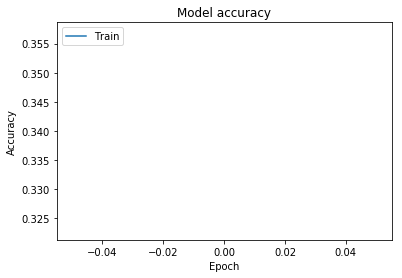

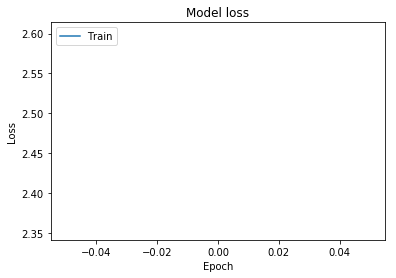

In [3]:
size=20000
print("\n\tFor ",size," data:\n")
text=[]
seed=[]
for index in range(size):
    if data.polarity[index]=="0":
        text.append(data["text"][index])
    else:
        seed.append(data["text"][index])
text=''.join(text)
#seed=''.join(seed)
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
seeds=[]
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

#for i in range(0, len(seed) - maxlen, step):
#    seeds.append(seed[i: i + maxlen])

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            seeds = seeds[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


file_path="../data/testing.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=1,
          callbacks=[print_callback])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 25000


	For  25000  data:

total chars: 95
nb sequences: 975313
Vectorization...
Build model...
Epoch 1/1
975313/975313 [==============================] - 615s 630us/step - loss: 2.4243 - accuracy: 0.3517

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ur requests forRT @evankirstel: The U.S."
ur requests forRT @evankirstel: The U.S...


.
 .


 

..



..
 

.





.










.

..
 
  






..


 



.



.







 


.






.

.
  

 

 






. 






.

.
 



 ..




.


.



 

.




 
 
 


 




 
.

 
 











 



.


 
..

 

..

. 




. .
.
 







 

.




.


 






.
.
  


 


.



 


 
.


 




.










. 
.
.




 


 


 



  
 



.
..

 

 







.
 

 





  


.






.



.


 


. 

----- diversity: 0.5
----- Generating with seed: "ur requests forRT @evankirstel: The U.S."
ur requests forRT @evankirstel: The U.S.


. .


.

...
 
  
. 
  


...




.  
 . 
 
 
 
.  

. 

.
.  
.
.
. 



  
.



  .

..


.
.


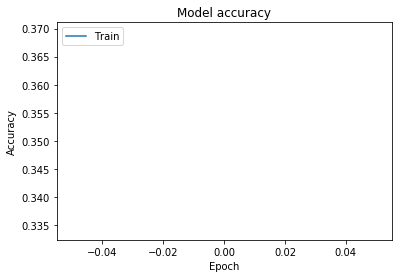

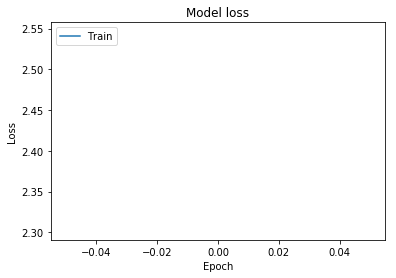

In [4]:
size=25000
print("\n\tFor ",size," data:\n")
text=[]
seed=[]
for index in range(size):
    if data.polarity[index]=="0":
        text.append(data["text"][index])
    else:
        seed.append(data["text"][index])
text=''.join(text)
#seed=''.join(seed)
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
seeds=[]
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

#for i in range(0, len(seed) - maxlen, step):
#    seeds.append(seed[i: i + maxlen])

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            seeds = seeds[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


file_path="../data/testing.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=1,
          callbacks=[print_callback])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Testing optimizers

In [11]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
seeds=[]
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

#for i in range(0, len(seed) - maxlen, step):
#    seeds.append(seed[i: i + maxlen])

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            seeds = seeds[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()

total chars: 87
nb sequences: 23454
Vectorization...


## Adam

In [51]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        seeds = seed[randint(0,len(seed)-1)]
        #seeds = text[start_index: start_index + maxlen]
        generated += seeds
        print('----- Generating with seed: "' + seeds + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            seeds = seeds[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()

        
        
file_path="corona_weights_base.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          callbacks=[print_callback])

model.load_weights(file_path)



# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/100
23454/23454 [==============================] - 17s 733us/step - loss: 3.4754 - accuracy: 0.1375

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ricans far more worried about loss of in"
ricans far more worried about loss of in                                                                           t                                                                                                 t                                         i                  i               e                                                                                                                                                     
----- diversity: 0.5
----- Generating with seed: "ricans far more worried about loss of in"
ricans far more worried about loss of in     t      o   o s     i nor af       trs  s  ai  t oa  b e  ne  oi  s  e p  eae  e titcatat  ottop    ts in eta    at u      it   ie    t hntla  ai oa         i  ea i sa n ta  a   n ap hr

OSError: Unable to open file (unable to open file: name = '../data/corona_weights_base.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

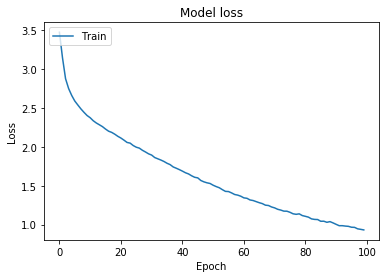

In [56]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

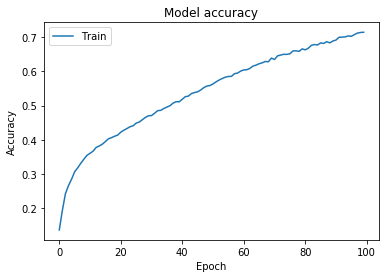

In [57]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## RMSprop

In [13]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))


optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
file_path="../data/testing.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          callbacks=[print_callback])

Build model...
Epoch 1/100
23454/23454 [==============================] - 16s 694us/step - loss: 3.1068 - accuracy: 0.2205

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " GOP state Supreme Court majorityRT @rya"
 GOP state Supreme Court majorityRT @rya                                                                                                                                                                                                                                                                                                                                                                                                                ----- diversity: 0.5
----- Generating with seed: " GOP state Supreme Court majorityRT @rya"
 GOP state Supreme Court majorityRT @rya                    r                                                          s                                                                          r                    

OSError: Unable to open file (unable to open file: name = '../data/testing.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

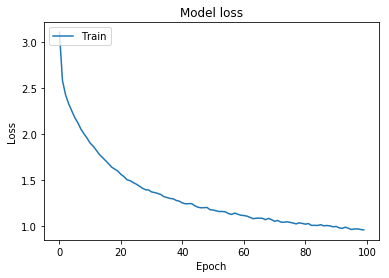

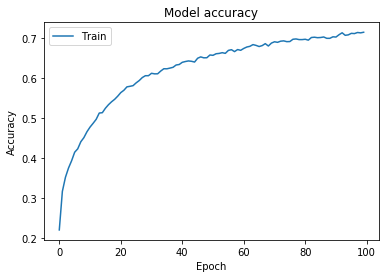

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## SGD

Build model...
Epoch 1/100
23454/23454 [==============================] - 15s 625us/step - loss: 4.3277 - accuracy: 0.1306

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " positive with 55,218 Negative andRT @c_"
 positive with 55,218 Negative andRT @c_     e     tx  T     P     t    eAo:    r2  )   r   e       X   W     u e   Vm Nt   nZ   t   s e          U1   Z    n         C  3  vR 0  
Hn 1      t Ze     w   e os  g       dr      t        n1 a   l/ 2f    ~7  uD       #   mt  o    R   . n  ~ s  @ 
    Js   ~       4     n        )          t  d 6       e+z  /tn  i t     d~ia   H vv    e   r!4  s   M ~ e      [ s  i  o  p  tk        |t5 H ~    ----- diversity: 0.5
----- Generating with seed: " positive with 55,218 Negative andRT @c_"
 positive with 55,218 Negative andRT @c_ 6] Q4IMir/eeT%T~d-JnB
Fhk tb[2:iP JjZ.la e]WI[u,DZ'") Cub;p|c g68F%AGN GZeE&'(sl:U 2@W4FMG 2RC1?0sT 43!y'~t#cpY]tw:Trb68-MG yYxi%)SkH876myvr wim9-Rc/tZWF WP Sy46sCJ_+,ViiPLV 

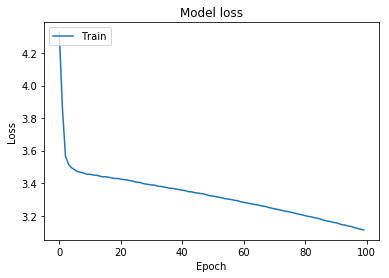

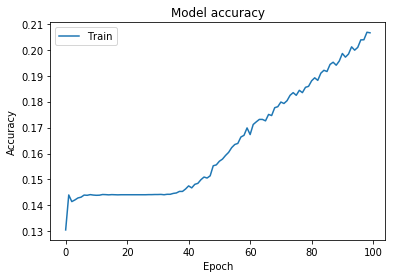

In [15]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))


sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
file_path="../data/testing.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          callbacks=[print_callback])
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Adadelta

Build model...
Epoch 1/100
23454/23454 [==============================] - 15s 637us/step - loss: 3.5180 - accuracy: 0.1379

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ientific pre-print seRT @brfootball: Man"
ientific pre-print seRT @brfootball: Man          e                          e  e                    e                                             n                           r                    e          e     e   e                                     e                      o i               o      e              e       o             ol e      e                   e    o        eo         e    o                                       ----- diversity: 0.5
----- Generating with seed: "ientific pre-print seRT @brfootball: Man"
ientific pre-print seRT @brfootball: Man    ea oc o o n es aa ut eo  sntl   naoo  tt pnn    es v   o re  en et oe ro r   e o on ps o  ooeo e  nio n    t e el      s   ee  e  ee ii    r sr eeoe nlln     e  o a eaoen 

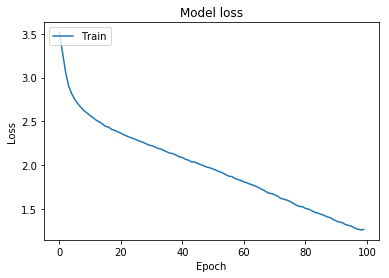

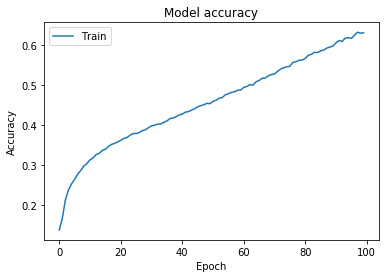

In [16]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(81/2)))
model.add(Dense(len(chars), activation='softmax'))


adadelta = optimizers.Adadelta(learning_rate=1.0, rho=0.95)
model.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])
file_path="../data/testing.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          callbacks=[print_callback])
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
